In [1]:
# import module
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
# DB data import
import cx_Oracle
import os
os.environ['LD_LIBRARY_PATH']=':/ORACLE/db/12c/lib'

con_fims2005 = cx_Oracle.connect('fimsr/vudrk_read@192.168.1.130:1521/FIMS2005')
cur_fims2005 = con_fims2005.cursor()
sql_query = "SELECT   A.STK_CD AS STK_CD \
           , A.STK_NM_KOR AS STK_NM \
           , B.TRD_DT AS TRD_DT \
           , B.OPEN_PRC AS OPEN_PRC \
           , B.HIGH_PRC AS HIGH_PRC \
           , B.LOW_PRC  AS LOW_PRC \
           , B.CLOSE_PRC AS CLOSE_PRC \
           , B.TRD_QTY AS TRD_QTY \
           , B.LIST_STK_CNT AS LIST_STK_CNT \
           , B.MKT_VAL AS MKT_VAL \
           , B.IP_DATE AS IP_DATE \
               FROM TSTW100 A \
                   , TSTW102 B \
               WHERE TRD_DT BETWEEN '20130101' AND '20181004'\
               AND A.STK_CD = '007070'\
               AND A.STK_CD = B.STK_CD"
gs       = pd.read_sql(sql_query, con_fims2005, index_col=None)
TRD_DT   = [datetime.datetime.strptime(gs.TRD_DT[i], "%Y%m%d") for i in range(len(gs))]
gs.index = TRD_DT
cur_fims2005.close()
con_fims2005.close()
gs.head()

,STK_CD,STK_NM,TRD_DT,OPEN_PRC,HIGH_PRC,LOW_PRC,CLOSE_PRC,TRD_QTY,LIST_STK_CNT,MKT_VAL,IP_DATE
2013-01-02,007070,GS???,20130102,30000,30550,29650,29650,231810,77000000,2283050000000,2013-01-03 20:31:42
2013-01-03,007070,GS???,20130103,29700,29850,27750,27850,663253,77000000,2144450000000,2013-01-04 21:04:27
2013-01-04,007070,GS???,20130104,28050,28450,27800,28300,495755,77000000,2179100000000,2013-01-07 21:23:19
2013-01-07,007070,GS???,20130107,28150,28400,27500,27950,322399,77000000,2152150000000,2013-01-08 20:58:58
2013-01-08,007070,GS???,20130108,27500,28400,27500,28150,244744,77000000,2167550000000,2013-01-09 20:45:20


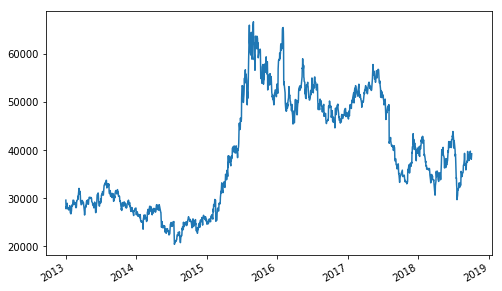

In [3]:
# GS리테일 종가 데이터 시각화
gs.CLOSE_PRC.plot(figsize= (8, 5))

In [4]:
## 일간 종가에 기반한 로그수익률
# 1. pct_change 함수
gs['Return'] = gs.CLOSE_PRC.pct_change()
gs['Return'][:10]

2013-01-02         NaN
2013-01-03   -0.060708
2013-01-04    0.016158
2013-01-07   -0.012367
2013-01-08    0.007156
2013-01-09    0.030195
2013-01-10   -0.037931
2013-01-11    0.001792
2013-01-14    0.003578
2013-01-15   -0.010695
Name: Return, dtype: float64

In [5]:
# 2. 빈 칼럼 생성후 for문으로 로그 수익률 하나씩 계산
#gs['Ret_Loop'] = ''
#for i in range(1, len(gs)):
#    gs['Ret_Loop'][i] = np.log(gs['CLOSE_PRC'][i] / gs['CLOSE_PRC'][i-1])
#gs[['CLOSE_PRC','Ret_Loop']]    

# 3. 백터화를 사용하여 반복문 없이 계산
#gs['Return'] = np.log(gs['CLOSE_PRC'] / gs['CLOSE_PRC'].shift(1))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fecee3e1390>,
      dtype=object)

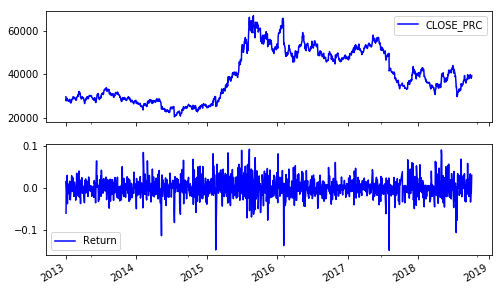

In [6]:
## gs리테일 주가와 일간 로드 수익률
# 변동성 군집현상: 변동성은 시간에 따라 일정하게 유지되지 않는다.(변동성이 높게 유지되는 구간 or 변동성이 낮게 유지되는 구간)
# 레버리지 효과: 일반적으로 변동성과 주식 시장 수익률은 음의 상관관계
gs[['CLOSE_PRC','Return']].plot(subplots=True, style='b', figsize=(8, 5))

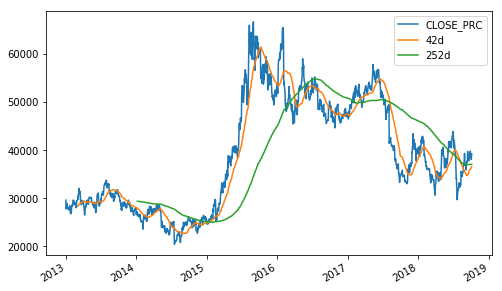

In [7]:
# 주식 트레이더(기술적 분석에 의지{추세선: 이동평균선})
gs['42d'] = gs['CLOSE_PRC'].rolling(window=42).mean() # (영업일 기준날짜의 주가 ~ 42일 전 주가)의 평균
gs['252d'] = gs['CLOSE_PRC'].rolling(window=252).mean()
gs[['CLOSE_PRC','42d','252d']].plot(figsize=(8, 5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fecee2baeb8>,
      dtype=object)

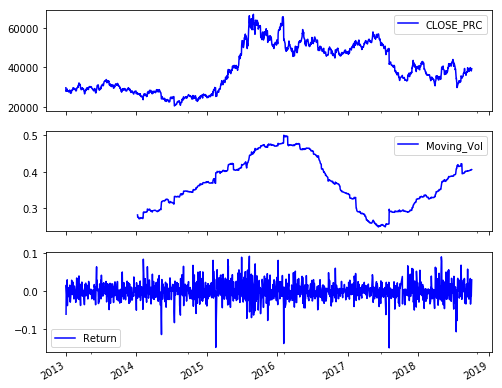

In [8]:
# 옵션 트레이더(로그 수익률의 이동 표준편차{이동 역사적 변동성})
# 교재의 DAX 지수는 레버리지 효과 가설(이동 변동성과 시장 주가는 음의 상관관계)을 뒷바침하나 주식 개별 종목은?
import math
gs['Moving_Vol'] = gs['Return'].rolling(window=252).std()*math.sqrt(252)
gs[['CLOSE_PRC','Moving_Vol','Return']].plot(subplots=True, style='b', figsize=(8, 7))

In [9]:
#### 6.3 회귀분석
## pandas를 이용해 정식적인 통계적인 근거에 기반한 분석가능(최소 제곱법애 기반한 선형회귀분석)
con_fims2005 = cx_Oracle.connect('fimsr/vudrk_read@192.168.1.130:1521/FIMS2005')
cur_fims2005 = con_fims2005.cursor()
sql_query1 = "SELECT GIJUN_YMD \
                   , BM_CD \
                   , BM_ENM \
                   , CUR \
                   , BM_JISU \
                   , BF_DEBI_RT \
                   , VOLUME \
                FROM TST502S1 \
                WHERE BM_ENM = 'CBOE S&P 500 Volatility Index' \
                ORDER BY GIJUN_YMD ASC"
sql_query2 = "SELECT GIJUN_YMD \
                   , BM_CD \
                   , BM_ENM \
                   , CUR \
                   , BM_JISU \
                   , BF_DEBI_RT \
                   , VOLUME \
                FROM TST502S1 \
                WHERE BM_ENM = 'S&P 500' \
                AND GIJUN_YMD >= '20060301' \
                ORDER BY GIJUN_YMD ASC"

vix         = pd.read_sql(sql_query1, con_fims2005, index_col=None)
sp500       = pd.read_sql(sql_query2, con_fims2005, index_col=None)
GIJUN_YMD   = [datetime.datetime.strptime(vix.GIJUN_YMD[i], "%Y%m%d") for i in range(len(vix))]
GIJUN_YMD2  = [datetime.datetime.strptime(sp500.GIJUN_YMD[i], "%Y%m%d") for i in range(len(sp500))]
vix.index   = GIJUN_YMD
sp500.index = GIJUN_YMD2
data        = pd.DataFrame({'SP500': sp500["BM_JISU"], 'VIX': vix["BM_JISU"]})
cur_fims2005.close()
con_fims2005.close()

data.head()

,SP500,VIX
2006-03-01,1291.24,11.54
2006-03-02,1289.14,11.72
2006-03-03,1287.23,11.96
2006-03-06,1278.26,12.74
2006-03-07,1275.88,12.66


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5aa25e02e8>,
      dtype=object)

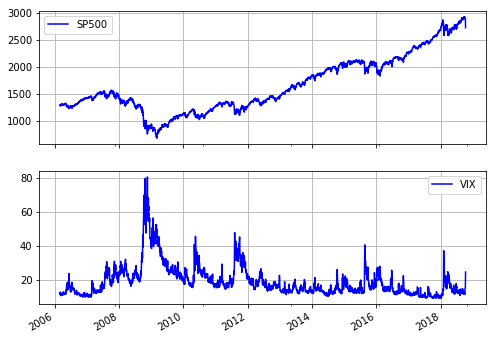

In [10]:
## 레버리지 효과: S&P 500 and VIX지수(S&P500지수 옵션 가격의 향후 30일 동안의 변동성에 대한 시장의 기대를 나타내는 지수)의 상관관계로 검증
data.plot(subplots=True, grid=True, style='b', figsize=(8, 6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fecee1bc7b8>,
      dtype=object)

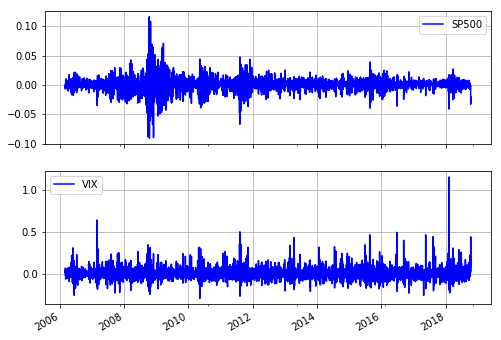

In [10]:
# 로그 수익률
data_return = data.pct_change()
data_return.plot(subplots=True, grid=True, style='b', figsize=(8, 6))

In [11]:
# 독립변수: S&P500수익률 & 종속변수: VIX수익률
# statsmodel package 설치 필요
import statsmodels.formula.api as sm
model = sm.OLS.from_formula("VIX ~ SP500", data=data_return).fit()
model.params
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    VIX   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     3547.
Date:                Fri, 12 Oct 2018   Prob (F-statistic):               0.00
Time:                        09:14:44   Log-Likelihood:                 4934.9
No. Observations:                3298   AIC:                            -9866.
Df Residuals:                    3296   BIC:                            -9854.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0045      0.001      4.720      0.000       0.003       0.006
SP500         -4.7289      0.079    -59.559      0.000      -4.885      -4.573
==============================================================================
Omnibus:                     2431.371   Durbin-Watson:                   2.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           187280.563
Skew:                           2.833   Prob(JB):                         0.00
Kurtosis:                      39.480   Cond. No.                         84.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'VIX returns')

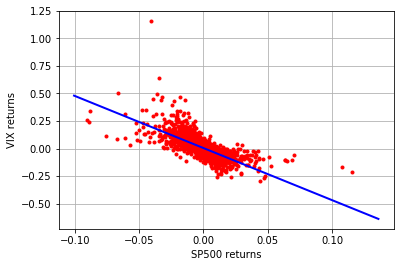

In [12]:
# 레버리지 효과 시각화
import matplotlib.pyplot as plt
plt.plot(data_return.SP500, data_return.VIX, 'r.')
ax = plt.axis()
x  = np.linspace(ax[0], ax[1] + 0.01)
plt.plot(x, model.params[0] + model.params[1]*x, 'b', lw=2)
plt.grid(True)
plt.axis('tight')
plt.xlabel('SP500 returns')
plt.ylabel('VIX returns')

In [13]:
# 두 시계열 값에서 상관계수
data_return.corr()

,SP500,VIX
SP500,1.000000,-0.719973
VIX,-0.719973,1.000000


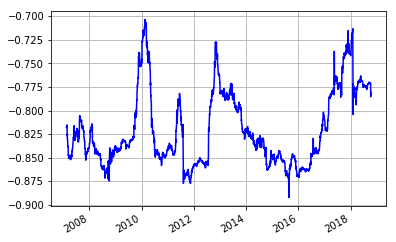

In [14]:
# 상관계수를 연 단위(252 매매일 기준)으로 계산
data_return['SP500'].rolling(window=252).corr(data_return['VIX']).plot(grid=True, style='b')